# IMDA Dataset processing

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [2]:
llm_result_df = pd.read_excel("../data/session1/IMDA_session1_V3b_gpt_0910_ra.xlsx")
print(llm_result_df.shape)
llm_result_df[['file_name','x_min', 'text','GPT4o']].head()

(258828, 14)


,file_name,x_min,text,GPT4o
0,app_0001_0010_phnd_cc-hol.TextGrid,0.00000,okay <mandarin>来来:lai lai</mandarin> okay <man...,0.00
1,app_0001_3002_phnd_cc-hol.TextGrid,0.00000,up okay,0.00
2,app_0001_3002_phnd_cc-hol.TextGrid,3.13000,so (ppo) okay so hello I'm calling to (err),0.00
3,app_0001_3002_phnd_cc-hol.TextGrid,7.97812,make some enquiry about (uh) travel,0.15
4,app_0001_3002_phnd_cc-hol.TextGrid,10.43370,trip to (uh) korea,0.15


In [3]:
# merge rule-based results : Textblob, VADER, Stanza
files_and_versions = [
    ("../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v2.csv", 2),
    ("../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v3.csv", 3),
    ("../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v5.csv", 5),
    ("../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v6.csv", 6),
    ("../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v8.csv", 8),    
]

dataframes = []

for file, version in files_and_versions:
    print(file)
    try:
        df = pd.read_csv(file)
    except:
        print(f"file {file} use ISO encoding")
        df = pd.read_csv(file, encoding='ISO-8859-1')
    df = df.drop(columns=['Unnamed: 0'])
    df = df.fillna(0)
    df = df.drop(columns=['session_id', 'speaker_id', 'speaker_type', 'dialog_type',
                         'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
                          'duration', 'qualified_for_sentiment','processed_text'])
    df['sentiment_label_VADER'] = pd.to_numeric(df['sentiment_label_VADER'], errors='coerce')
    df['sentiment_label_TextBlob'] = pd.to_numeric(df['sentiment_label_TextBlob'], errors='coerce')
    df['sentiment_label_Stanza'] = pd.to_numeric(df['sentiment_label_Stanza'], errors='coerce')
    # Rename sentiment-related columns
    df = df.rename(columns={
        'sentiment_label_VADER': f'V-{version}',
        'sentiment_label_TextBlob': f'T-{version}',
        'sentiment_label_Stanza': f'S-{version}'
    })
    # Append the DataFrame to the list
    dataframes.append(df)

# Merge the DataFrames on 'file_name', 'speaker_id', 'x_min'
# Use reduce to merge multiple DataFrames iteratively
from functools import reduce

rule_based_results_df = reduce(lambda left, right: pd.merge(left, right, on=['file_name', 'x_min'], how='inner'), dataframes)
rule_based_results_df = rule_based_results_df.dropna()
# Display the first few rows of the merged DataFrame
print(rule_based_results_df.shape)
rule_based_results_df[['file_name','x_min', 'V-2','T-3','S-5','S-6', 'S-8']].head()
#['file_name', 'x_min', 'V-2', 'T-2', 'S-2', 'V-3', 'T-3', 'S-3', 'V-5','T-5', 'S-5', 'V-6', 'T-6', 'S-6', 'V-8', 'T-8', 'S-8']

../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v2.csv
file ../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v2.csv use ISO encoding
../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v3.csv
file ../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v3.csv use ISO encoding
../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v5.csv
../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v6.csv
../data/session1/IMDA_original2_FILTERED_137K_sentiment_0908-v8.csv
(133425, 45)


,file_name,x_min,V-2,T-3,S-5,S-6,S-8
0,app_0001_3002_phnd_cc-hol.TextGrid,18.58958,0.0000,0.100000,0.0,0,0.0
1,app_0001_3002_phnd_cc-hol.TextGrid,25.79000,0.3612,0.000000,0.0,0,0.0
2,app_0001_3002_phnd_cc-hol.TextGrid,32.49143,0.3612,0.058929,-1.0,-1,-1.0
3,app_0001_3002_phnd_cc-hol.TextGrid,41.16000,0.0000,-0.033333,-1.0,-1,-1.0
4,app_0001_3002_phnd_cc-hol.TextGrid,46.47164,0.0000,0.000000,0.0,0,0.0


In [4]:
# Drop columns that start with 'Unnamed' and end with '_x'
rule_based_results_df = rule_based_results_df.drop(rule_based_results_df.filter(regex='^Unnamed:.*_x$').columns, axis=1)
rule_based_results_df = rule_based_results_df.drop(rule_based_results_df.filter(regex='^Unnamed:.*_y$').columns, axis=1)

# Display the updated DataFrame
rule_based_results_df.dtypes

file_name     object
x_min        float64
V-2          float64
T-2          float64
S-2          float64
V-3          float64
T-3          float64
S-3          float64
V-5          float64
T-5          float64
S-5          float64
V-6          float64
T-6          float64
S-6            int64
V-8          float64
T-8          float64
S-8          float64
dtype: object

In [5]:
merged_df = pd.merge(llm_result_df, rule_based_results_df, on=['file_name', 'x_min'], how='right')
print(merged_df.shape)
merged_df[['file_name','x_min', 'text','GPT4o','V-2','T-3','S-5','S-6', 'S-8']].head()

(137713, 29)


,file_name,x_min,text,GPT4o,V-2,T-3,S-5,S-6,S-8
0,app_0001_3002_phnd_cc-hol.TextGrid,18.58958,one of the adult is wheelchair bound which is ...,-0.15,0.0000,0.100000,0.0,0,0.0
1,app_0001_3002_phnd_cc-hol.TextGrid,25.79000,my spouse and myself and my two children and (...,0.00,0.3612,0.000000,0.0,0,0.0
2,app_0001_3002_phnd_cc-hol.TextGrid,32.49143,first for the air airplane right I would like ...,0.15,0.3612,0.058929,-1.0,-1,-1.0
3,app_0001_3002_phnd_cc-hol.TextGrid,41.16000,to the toilet so it's more convenient for my (...,0.30,0.0000,-0.033333,-1.0,-1,-1.0
4,app_0001_3002_phnd_cc-hol.TextGrid,46.47164,parent and also my kids because you know the t...,0.30,0.0000,0.000000,0.0,0,0.0


In [6]:
merged_df[[ 'GPT4o', 'V-2', 'V-3', 'V-5', 'V-6', 'V-8', 
               'T-2','T-3', 'T-5','T-6','T-8', 
               'S-3', 'S-2','S-5','S-6','S-8']].corr().round(3)

,GPT4o,V-2,V-3,V-5,V-6,V-8,T-2,T-3,T-5,T-6,T-8,S-3,S-2,S-5,S-6,S-8
GPT4o,1.000,0.386,0.321,0.322,0.387,0.322,0.264,0.231,0.231,0.272,0.231,0.339,0.369,0.347,0.355,0.346
V-2,0.386,1.000,0.872,0.869,0.984,0.869,0.445,0.426,0.426,0.449,0.426,0.308,0.333,0.302,0.297,0.303
V-3,0.321,0.872,1.000,0.997,0.874,0.995,0.415,0.478,0.477,0.415,0.477,0.331,0.271,0.324,0.238,0.325
V-5,0.322,0.869,0.997,1.000,0.872,0.999,0.414,0.476,0.476,0.414,0.476,0.332,0.271,0.325,0.238,0.327
V-6,0.387,0.984,0.874,0.872,1.000,0.872,0.441,0.421,0.421,0.444,0.421,0.309,0.332,0.303,0.300,0.304
V-8,0.322,0.869,0.995,0.999,0.872,1.000,0.413,0.475,0.475,0.414,0.476,0.332,0.271,0.325,0.238,0.327
T-2,0.264,0.445,0.415,0.414,0.441,0.413,1.000,0.891,0.891,0.981,0.891,0.292,0.290,0.307,0.282,0.308
T-3,0.231,0.426,0.478,0.476,0.421,0.475,0.891,1.000,0.999,0.898,0.999,0.297,0.263,0.314,0.253,0.315
T-5,0.231,0.426,0.477,0.476,0.421,0.475,0.891,0.999,1.000,0.898,1.000,0.297,0.263,0.314,0.252,0.315
T-6,0.272,0.449,0.415,0.414,0.444,0.414,0.981,0.898,0.898,1.000,0.898,0.295,0.291,0.310,0.287,0.311


In [7]:
# Extracting the VADER, TextBlob, and Stanza columns for comparison
'''CONFIGURABLE'''
vader_columns = ['V-2', 'V-3'] # [col for col in merged_df.columns if col.startswith('V-')]
textblob_columns = ['T-2', 'T-3'] # [col for col in merged_df.columns if col.startswith('T-')]
stanza_columns = ['S-2', 'S-3', 'S-5' ,'S-6','S-8']  #[col for col in merged_df.columns if col.startswith('S-')]

# Define the sentiment classification function based on the provided thresholds
def classify_sentiment_vader(score):
    if -0.05 <= score <= 0.5:
        return 'neutral'
    elif score > 0.5:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_textblob(score):
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.3:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_stanza(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.05:
        return 'neutral'
    elif score > 0.05:
        return 'positive'
    else:
        return 'negative'

# Apply classification to each sentiment analysis method
for col in vader_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_vader)

for col in textblob_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_textblob)

for col in stanza_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_stanza)


### Plots

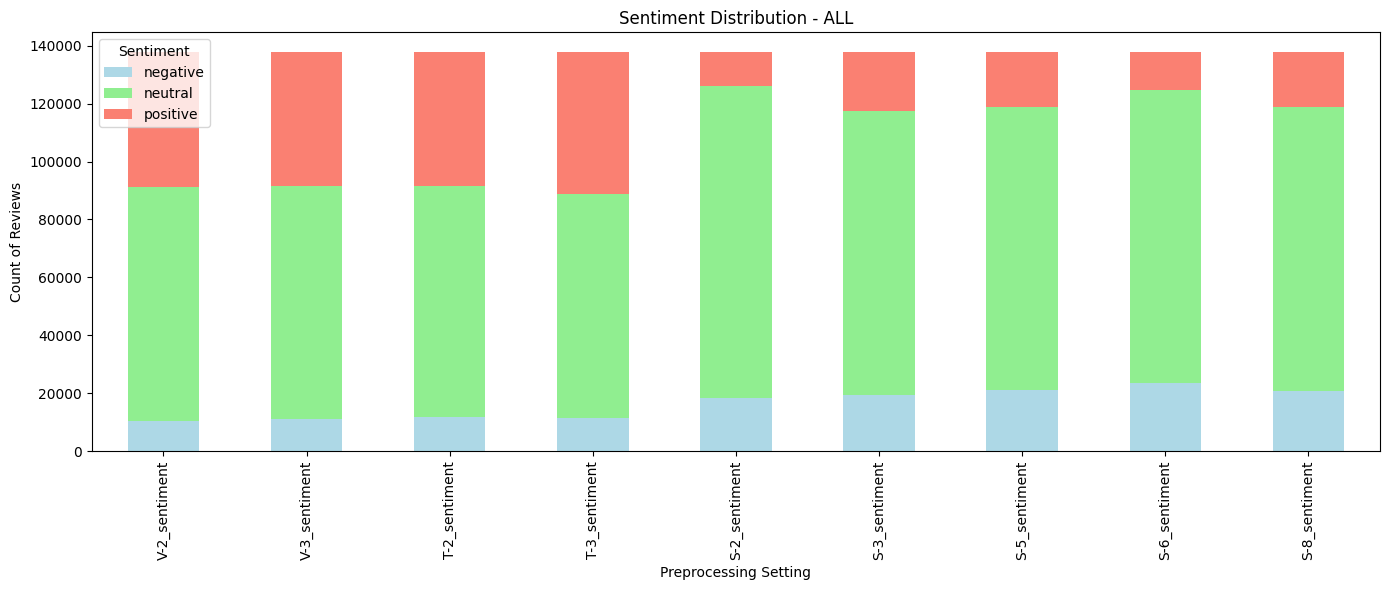

In [8]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
distribution = merged_df[[f'{col}_sentiment' for col in vader_columns +textblob_columns + stanza_columns ]].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - ALL')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()



## Rule based voting

In [9]:
# Map the sentiment labels to integers
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Apply classification to each sentiment analysis method
for col in vader_columns + textblob_columns + stanza_columns:
    merged_df[f'{col}_vote'] = merged_df[col + '_sentiment'].map(label_mapping)

vote_columns = [col for col in merged_df.columns if col.endswith('_vote')]
# Calculate the total votes for each review
merged_df['sum_score'] = merged_df[vote_columns].sum(axis=1)

In [10]:
# Calculate the maximum frequency and identify the corresponding sentiment
def determine_max_sentiment(pos_count, neg_count, neu_count):
    max_frequency = max(pos_count, neg_count, neu_count)
    
    if max_frequency == pos_count and pos_count > max(neg_count, neu_count):
        return 'positive', max_frequency
    elif max_frequency == neg_count and neg_count > max(pos_count, neu_count):
        return 'negative', max_frequency
    elif max_frequency == neu_count and neu_count > max(neg_count, pos_count):
        return 'neutral', max_frequency
    else:
        return 'tie', max_frequency

# Function to calculate the highest frequency of a value in a row
def calculate_highest_frequency(row):
    # Count the occurrences of each vote
    pos_count = sum(row[col] == 1 for col in vote_columns)
    neg_count = sum(row[col] == -1 for col in vote_columns)
    neu_count = sum(row[col] == 0 for col in vote_columns)
    
    max_sentiment, max_frequency = determine_max_sentiment(pos_count, neg_count, neu_count)
    return max_sentiment, max_frequency


merged_df[['rule_based_label', 'max_agreement_votes']] = merged_df.apply(
    lambda row: calculate_highest_frequency(row), axis=1, result_type='expand'
)

merged_df[['rule_based_label', 'max_agreement_votes']].head()

,rule_based_label,max_agreement_votes
0,neutral,9
1,neutral,9
2,neutral,5
3,negative,5
4,neutral,9


In [11]:
'''CONFIGURABLE'''
merged_df['others_agree_with_each_other'] = merged_df['max_agreement_votes']>= 6 
merged_df['others_agree_with_each_other'].value_counts()
merged_df['vader_avg'] = merged_df[vader_columns].mean(axis=1)
merged_df['textblob_avg'] = merged_df[textblob_columns].mean(axis=1)
merged_df['stanza_avg'] = merged_df[stanza_columns].mean(axis=1)

merged_df['rule_based_score'] = merged_df[['vader_avg', 'textblob_avg', 'stanza_avg']].mean(axis=1)

columns_to_be_dropped = ['V-2', 'T-2', 'S-2', 'V-3','T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 
'V-8', 'T-8','S-8','V-2_sentiment', 'V-3_sentiment', 'T-2_sentiment', 'T-3_sentiment', 'S-2_sentiment',
'S-3_sentiment', 'S-5_sentiment', 'S-6_sentiment', 'S-8_sentiment','V-2_vote', 'V-3_vote', 'T-2_vote', 'T-3_vote', 'S-2_vote', 'S-3_vote',
'S-5_vote', 'S-6_vote', 'S-8_vote']
merged_df = merged_df.drop(columns = columns_to_be_dropped)

## LLM (OpenAI GPT 4o mini

In [12]:
merged_df['GPT4o'].value_counts()

GPT4o
 0.30    40916
 0.00    32626
 0.50    28152
 0.70    12170
-0.50     6492
 0.15     5439
-0.70     5186
-0.30     4827
-0.15     1129
-0.80      134
-0.90       62
-1.00       36
 0.80       32
 1.00       22
-0.60        8
 0.90        3
-0.40        1
Name: count, dtype: int64

In [13]:
'''CONFIGURABLE'''
def classify_sentiment_GPT4o(score):
    if -0.1 <= score <= 0.3:
        return 'neutral'
    elif score > 0.35:
        return 'positive'
    else:
        return 'negative'

merged_df['GPT4o_label'] = merged_df['GPT4o'].apply(classify_sentiment_GPT4o)
merged_df['GPT4o_label'].value_counts()

GPT4o_label
neutral     78981
positive    40379
negative    18353
Name: count, dtype: int64

In [14]:
merged_df['others_agree_with_LLM'] = merged_df['rule_based_label']==merged_df['GPT4o_label']
merged_df['others_agree_with_LLM'].value_counts()

others_agree_with_LLM
True     85701
False    52012
Name: count, dtype: int64

In [15]:
merged_df['others_agree_with_each_other'].value_counts()

others_agree_with_each_other
True     101941
False     35772
Name: count, dtype: int64

In [16]:
# Function to calculate final sentiment score
def calculate_final_sentiment(row): 
    if not row['others_agree_with_each_other']:
        # If others don't agree with each other
        final_score = row['GPT4o'] * 1.0  # GPT4o 1, others 0
    else:
        # If others agree with each other
        if row['others_agree_with_LLM']:
            final_score = row['GPT4o'] * 0.7 + row['rule_based_score'] * 0.3  # GPT4o 0.7, others 0.3
        else:
            final_score = row['GPT4o'] * 0.8 + row['rule_based_score'] * 0.2  # GPT4o 0.8, others 0.2
    return final_score

# Apply the function to calculate the final sentiment score
merged_df['final_sentiment_score'] = merged_df.apply(calculate_final_sentiment, axis=1)

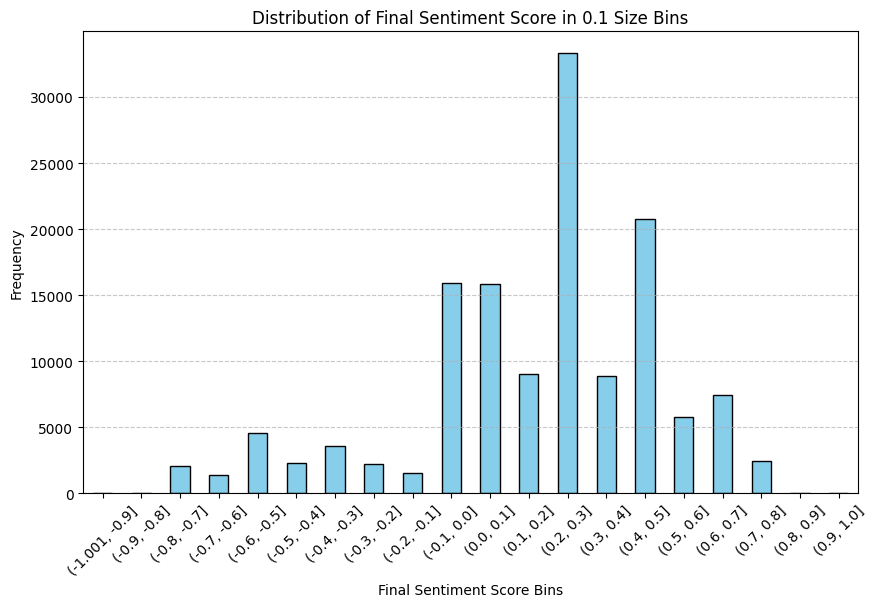

final_sentiment_score
(-1.001, -0.9]       30
(-0.9, -0.8]         64
(-0.8, -0.7]       2065
(-0.7, -0.6]       1417
(-0.6, -0.5]       4539
(-0.5, -0.4]       2309
(-0.4, -0.3]       3557
(-0.3, -0.2]       2261
(-0.2, -0.1]       1515
(-0.1, 0.0]       15888
(0.0, 0.1]        15877
(0.1, 0.2]         9043
(0.2, 0.3]        33305
(0.3, 0.4]         8879
(0.4, 0.5]        20806
(0.5, 0.6]         5810
(0.6, 0.7]         7424
(0.7, 0.8]         2415
(0.8, 0.9]           13
(0.9, 1.0]           18
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(merged_df['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Final Sentiment Score in 0.1 Size Bins')
plt.xlabel('Final Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

In [18]:
def classify_sentiment_final(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.1:
        return 'positive'
    else:
        return 'negative'
merged_df['final_sentiment_label'] = merged_df['final_sentiment_score'].apply(classify_sentiment_final)
merged_df['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     73008
positive    45365
negative    19340
Name: count, dtype: int64

In [19]:
merged_df[merged_df['others_agree_with_LLM']==True]['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     64299
positive    13616
negative     7786
Name: count, dtype: int64

In [20]:
merged_df.to_csv("../data/session1/IMDA_session1_merged_rule_n_GPT4o.csv",index=False)

In [21]:
agreed_df = merged_df[merged_df['others_agree_with_LLM']==True]
agreed_df[agreed_df['final_sentiment_label']=='negative'].sort_values(by='final_sentiment_score')['cleaned_text_for_sentiment'].head().values

array(['I mean this this this is a no go okay this is a big no go and I mean in the future for I d like I d like you to fire this guy because seriously this this is just irresponsible to the max I mean',
       'absurd considering the fact that you are you are supposed to be a five star hotel and I get the quality of a one star hotels [lah] like to say (um) I m terribly disappointed at',
       'poisoning [lah] we had a bad diarrhoea and we needed to go and see the the doctors (um) after consuming your food so (uh)',
       'so ya it was a bad experience',
       'everything is bad everything is so bad I cannot put a finger to which [one] is more more bad than that'],
      dtype=object)

In [22]:
# merged_df = merged_df.assign(Speed=lambda x: x['word_count']/x['duration'])
# merged_df_filtered = merged_df[(merged_df['duration']<8) & (merged_df['Speed']>1.8)]
# merged_df_filtered['final_sentiment_label'].value_counts()